## This project will examine how COVID has affected graffiti in San Francisco through use of the SF 311 API
- Graffiti complaints have increased this year with COVID

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


### Query graffiti data:

In [2]:
# Query Graffiti 311 data through API: (50k entries)
app_token = 'vWmXiIsPgC3AdJZayzXihvrtP'
graffiti = pd.DataFrame()
total_entries = 50000
for offset in range(0,total_entries,1000):
    query = f"https://data.sfgov.org/resource/vw6y-z8j6.json?$$app_token={app_token}&$limit=1000&$offset={offset}&service_name=Graffiti"
    graffiti = graffiti.append(pd.read_json(query.replace(" ","%20")),ignore_index=True)

### Clean and create some relevant timing data:

In [3]:
# Keep subset:
graffiti = graffiti[['requested_datetime','closed_date','service_subtype','service_details',
                     'supervisor_district','neighborhoods_sffind_boundaries',
                    'lat','long']]
# drop rows where there exist no location info:
graffiti.drop(graffiti[graffiti['lat']==0].index,inplace=True)
graffiti['closed_date'] = pd.to_datetime(graffiti['closed_date']) 
graffiti['requested_datetime'] = pd.to_datetime(graffiti['requested_datetime'])

In [4]:
graffiti['month'] = pd.DatetimeIndex(graffiti['requested_datetime']).month
graffiti['year'] = pd.DatetimeIndex(graffiti['requested_datetime']).year
dt = graffiti['closed_date']-graffiti['requested_datetime']
graffiti['resolution_time'] = dt.dt.total_seconds()/3600 # minutes
graffiti['day_opened'] = graffiti['requested_datetime'].dt.day_name()
graffiti['day_closed'] = graffiti['closed_date'].dt.day_name()
graffiti = graffiti[graffiti['supervisor_district']>0]

### Graffiti complaints have spiked since COVID

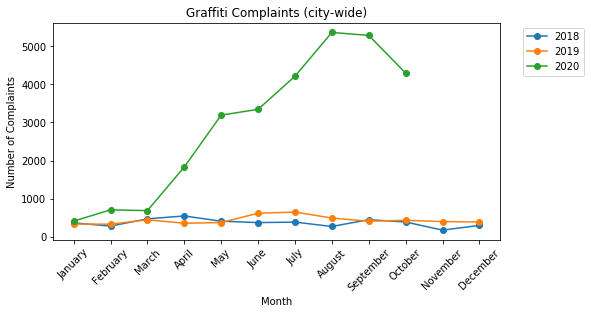

In [5]:
new_df = graffiti[graffiti['year'].between(2018,2020)]
complaints = pd.pivot_table(new_df[['year','month','resolution_time']],values='resolution_time',index = 'year',columns='month',aggfunc='count')
cols = ['January','February','March','April','May','June','July','August','September','October','November','December']
complaints.columns = cols
# Remove this month and next:
complaints['November'][2020] = np.nan
complaints['December'][2020] = np.nan
plt.figure(figsize=(8,4))
plt.plot(complaints.T,marker='o')
plt.legend(complaints.index,bbox_to_anchor=(1.2, 1), loc='upper right', ncol=1)
plt.xlabel('Month')
plt.ylabel('Number of Complaints')
plt.title('Graffiti Complaints (city-wide)')
plt.xticks(rotation=45)
plt.show()

### Which neighborhoods have been most affected?

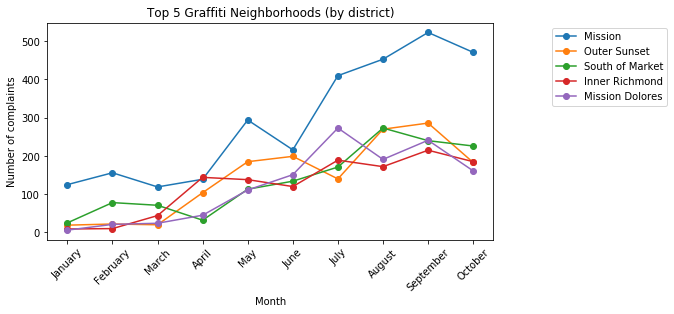

In [6]:
df_2020 = graffiti[graffiti['year']==2020]
cols = ['January','February','March','April','May','June','July','August','September','October']
complaints_2020 = pd.pivot_table(df_2020[['neighborhoods_sffind_boundaries','month','resolution_time']],values='resolution_time',index = 'neighborhoods_sffind_boundaries',columns='month',aggfunc='count')
complaints_2020 = complaints_2020.iloc[:,0:-1]
complaints_2020.columns = cols
x = complaints_2020.mean(axis=1).sort_values(ascending=False).head(5).index # top 5 neighborhoods
top_5 = complaints_2020.loc[[x[0],x[1],x[2],x[3],x[4]]]
plt.figure(figsize=(8,4))
plt.plot(top_5.T,marker='o')
plt.legend(top_5.index,bbox_to_anchor=(1.4, 1), loc='upper right', ncol=1)
plt.xlabel('Month')
plt.ylabel('Number of complaints')
plt.title('Top 5 Graffiti Neighborhoods (by district)')
plt.xticks(rotation=45)
plt.show()

### Is there a pattern to when graffiti is reported in these neighborhoods?

In [7]:
top_complaints = list(complaints_2020.mean(axis=1).sort_values(ascending=False).head(5).index) # top 5 neighborhoods
df_top_covid = graffiti[(graffiti['year']==2020) & (graffiti['neighborhoods_sffind_boundaries'].isin(top_complaints)) 
                            & (graffiti['month']>3)]
df_top_precovid = graffiti[(graffiti['year']==2019) & (graffiti['neighborhoods_sffind_boundaries'].isin(top_complaints))]

covid = pd.pivot_table(df_top_covid[['neighborhoods_sffind_boundaries','day_opened','resolution_time']],values='resolution_time',index = 'neighborhoods_sffind_boundaries',columns='day_opened',aggfunc='count')
covid = covid.reindex(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'],axis=1)

pre_covid = pd.pivot_table(df_top_precovid[['neighborhoods_sffind_boundaries','day_opened','resolution_time']],values='resolution_time',index = 'neighborhoods_sffind_boundaries',columns='day_opened',aggfunc='count')
pre_covid = pre_covid.reindex(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'],axis=1)


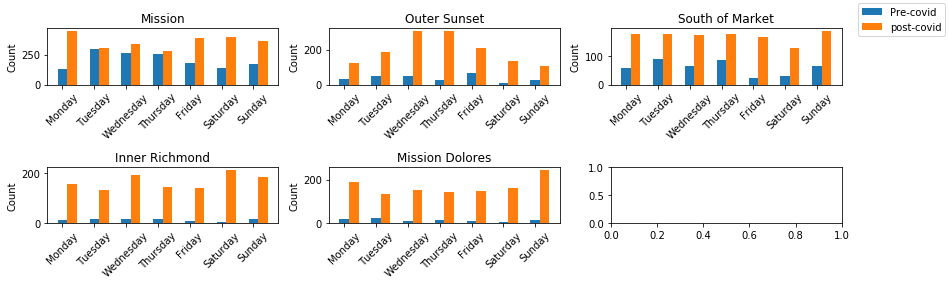

In [8]:
fig,ax = plt.subplots(nrows=2,ncols=3,figsize=(12,4))
ax = ax.flatten()
barWidth = .3
r1 = np.arange(len(covid.T))
r2 = [x + barWidth for x in r1]
for i,neighborhood in enumerate(top_complaints):
    ax[i].bar(r1,pre_covid.loc[neighborhood],width=barWidth)
    ax[i].bar(r2,covid.loc[neighborhood],width=barWidth)
    ax[i].set_xticklabels(covid.columns,rotation=45)
    ax[i].set_xticks(range(7))
    ax[i].set_ylabel('Count')
    ax[i].set_title(neighborhood)
fig.legend(['Pre-covid','post-covid'],bbox_to_anchor=(1.1, 1), loc='upper right')
plt.tight_layout()
plt.show()
# DO THIS PRE AND POST COVID (SAME TIME: 2019 and 2020)

### It looks like there might be some hooligans in the OUTER SUNSET who vandalize mid-week?

### Check out on the Map:

In [10]:
df_outer_sunset = graffiti[(graffiti['year']==2020) & (graffiti['neighborhoods_sffind_boundaries']=='Outer Sunset') 
                            & (graffiti['month']>3) & (graffiti['day_opened']=='Wednesday')]

In [12]:
import folium
graffiti_coords = df_outer_sunset[['lat','long']].to_numpy()
SF_COORDINATES = (37.76, -122.45)
m = folium.Map(
    SF_COORDINATES,
    zoom_start=13
)
for each in graffiti_coords:
    folium.CircleMarker(
        location = (each[0],each[1]),
        radius = 1,clustered_marker=True).add_to(m)
display(m)